# Predicting a loan's success in kiva's crowdfinding platform
## Human-Agent interaction final project
### By Einat Heletz and Eyal Golan

# Table of Contents
1. [Introduction](#intro)
2. [Preprocessing](#preprocessing)
3. [Feature Engineering](#features)
4. [Encoding](#encoding)
5. [Models](#models)
5. [Conclusions](#conclusions)

# <a class="anchor" id="intro">1. Introduction</a>
<b>What is Kiva?</b><br>
Kiva is a non-profit organization that allows people to lend money via the Internet to low-income entrepreneurs and
students in 77 countries.
Kiva's mission is "to expand financial access to help underserved communities thrive."
Since 2005, Kiva has crowd-funded more than 1.6 million loans, totaling over $1.33 billion, with a repayment rate of 
95.8 percent. Over 1.8 million lenders worldwide use the Kiva platform. Lenders do not receive interest on the money 
they lend. Kiva includes personal stories of each person who applies for a loan so that lenders can connect with 
borrowers on a human level.<br>
<br><br>
<b>Motivation</b><br>
The Kiva platform is used to extend financial services to poor and financially excluded people around the world.
It's lenders have provided over billions of dollars in loans to millions of people.
In order to inform lenders, set investment priorities and understand the lenders target communities -
knowing the poverty level of each borrower is important.
However, this requires inference based on limited information for each borrower.
<br><br>
<b>Our goal</b><br>
As part of out final project in the Human-Agent interaction course, our goal is to determine which factors come to play
in a lender's decision to provide a load or not - Which factors give a lender the security he or she needs that they
will get the money back? which people do lenders tend to trust? why?

## 1.1 Data
1. [Data Science for Good: Kiva Crowdfunding](https://www.kaggle.com/kiva/data-science-for-good-kiva-crowdfunding)
2. We also used the [MPI datasets](https://www.kaggle.com/ophi/mpi) in order to get the poverty level of a given location

Explaining the data:
1. Kiva Crowdfunding - we use the following kiva_loans.csv dataset. The dataset contains the following fields:
   * id	- int, the id number of the loan request
   * funded_amount - The amount disbursed by Kiva to the field agent(USD)
   * loan_amount - The amount disbursed by the field agent to the borrower(USD)
   * activity - The activity for which the load is requested
   * sector - The category of the activity
   * use - The purpose of the load
   * country_code - ISO country code of country in which loan was disbursed
   * country - Full country name of country in which loan was disbursed
   * region - Full region name within the country
   * currency - The currency in which the loan was disbursed
   * partner_id - Unique ID for field partners
   * posted_time
   * disbursed_time
   * funded_time
   * term_in_months
   * lender_count
   * tags - Additional information about the load, for example: #Woman Owned Biz, #Parent, #First Loan
   * borrower_genders - the gender of each of the borrowers

2. MPI - we use the following datasets:
   * MPI_national.csv - The dataset contains the following fields:
     * ISO - Unique ID for country
     * Country - country name
     * MPI Urban - Multi-dimensional poverty index for urban areas within the country
     * Headcount Ratio Urban - Poverty headcount ratio (% of population listed as poor) within urban areas within the country
     * Intensity of Deprivation Urban - Average distance below the poverty line of those listed as poor in urban areas
     * MPI Rural - Multi-dimensional poverty index for rural areas within the country
     * Headcount Ratio Rural - Poverty headcount ratio (% of population listed as poor) within rural areas within the country
     * Intensity of Deprivation Rural - Average distance below the poverty line of those listed as poor in rural areas

   * MPI_subnational.csv - The dataset contains the following fields:
     * ISO: Unique ID for country
     * Country: country name
     * Sub-national region: Region within country
     * World region: General global region
     * MPI National: Overall aggregate national MPI score
     * MPI Regional: Multi-dimensional poverty index for this region
     * Headcount Ratio Regional: Poverty headcount ratio (% of population listed as poor) this region
     * Intensity of deprivation Regional: Average distance below the poverty line of those listed as poor in this region

# <a class="anchor" id="preprocessing">2. Preprocessing</a>

## 2.1 Loading the data

In [1]:
import pandas as pd
import numpy as np
import math
import nltk
from nltk.tokenize import RegexpTokenizer
from tqdm import tqdm
import warnings
import seaborn as sns

In [2]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    tqdm.pandas()

print("Loading the datasets ...")
loans = pd.read_csv(r"datasets/kiva_loans.csv")
mpi_region = pd.read_csv(r"datasets/MPI_subnational.csv")
mpi_country = pd.read_csv(r"datasets/MPI_national.csv")
print("Loaded all the datasets")

Loading the datasets ...
Loaded all the datasets


## 2.2 Labeling
### 2.2.1 Amounts and labeling
We will classify the loans into 2 categories - 
1. Successful - A loan which has been fully funded by Kiva lender,
2. Unsuccessful - A partialy funded loan.
<br>

The label will be based on the following condition:<br>
loan_amount - funded_amount == 0

unsuccessful loans: 48328, successful loans: 622875


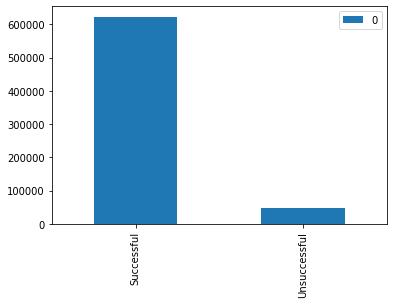

In [3]:
unsuccessful_loans_df = loans[loans['funded_amount'] < loans['loan_amount']]
successful_loans_df = loans[loans['funded_amount'] == loans['loan_amount']]
print(f'unsuccessful loans: {len(unsuccessful_loans_df)}, successful loans: {len(successful_loans_df)}')

ax = pd.DataFrame([len(successful_loans_df), len(unsuccessful_loans_df)], index=["Successful", "Unsuccessful"]).plot(kind="bar")

In [4]:
successful_loans_df.loc[:,'Key'] = 'Successful'
unsuccessful_loans_df.loc[:,'Key'] = 'Unsuccessful'
loans_with_label = pd.concat([successful_loans_df, unsuccessful_loans_df]).reset_index(drop=True)

C:\Users\eyalg\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\eyalg\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


### 2.2.2 Dealing with imbalanced data
As it can be seen, the data isn't balanced, since (fortunately) most of the loans were successfully funded. <br>
We present 3 different techniques to deal with it:<br>
- <b>reduction of the succesful samples</b> - since there are less unsuccessful samples, an appropriate approach is not to use all the successful loans data.
- <b>oversampling</b> - duplication of existing unsuccessful samples in order to enlarge the data set size.using imbalance datasets
- <b>using imbalanced data sets</b> - by that taking more successful loans than unsuccessful loans. The simplest approach, but might lead to biases (the results were bad, so won't be presented here).


#  <a class="anchor" id="features">3. Feature engineering</a>
We will take fields from different columns and generate features from them. Some examples:
1. Tags - some interesting tags can produce a boolean feature (exists or not)
2. "is_funded" (boolean) - loan_amount - funded_amount == 0

## 3.1 Gender Features
We will extract 3 features: amount of borrowers, the existence of a feminine and the existence of a masculine.<br>
In case of missing value in the borrower_genders field, the values are defined as follows, correspondingly: 0, False, False.

In [5]:
loans_with_label['borrowers_amount'] = loans_with_label.apply(lambda r:len(r.borrower_genders.split(',')) if type(r.borrower_genders) is str else 0, axis=1)
loans_with_label['has_female'] = loans_with_label.apply(lambda r:'female' in r.borrower_genders.split(',') if type(r.borrower_genders) is str else False, axis=1)
loans_with_label['has_male'] = loans_with_label.apply(lambda r:'male' in r.borrower_genders.split(',') if type(r.borrower_genders) is str else False, axis=1)

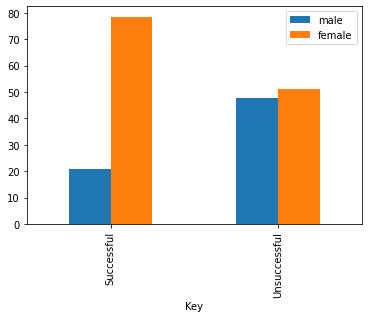

In [6]:
males_count = loans_with_label.groupby(['Key', 'has_male']).size().unstack('has_male')[True]
females_count = loans_with_label.groupby(['Key', 'has_female']).size().unstack('has_female')[True]
gender_df = pd.DataFrame([males_count, females_count], index=['male', 'female'])
gender_df["Successful"] = gender_df["Successful"].apply(lambda x: x / len(successful_loans_df) * 100)
gender_df["Unsuccessful"] = gender_df["Unsuccessful"].apply(lambda x: x / len(unsuccessful_loans_df) * 100)
ax = gender_df.transpose().plot(kind="bar")

 #### Results
 This barplot shows the percentage of loans with male and female borrowers in successful and unsuccessful loans separately

## 3.2 Loans use extraction
The use column contains free text for the lenders to descrive the purpose of their loan. <br> 
First we will take a quick look at the data using wordcloud to get the genreral idea for the usage of the loans, and what the lenders need the money for. <br>
And then we'll extract some features from the text.

### 3.2.1 Exploring
The use columns is a free text that describes the purpose of the loan, using a wordcloud can give the essence of successful and unsuucessful loans.

In [7]:
import nltk
nltk.download('stopwords')

stop_words = set(nltk.corpus.stopwords.words('english')) 
tokenizer = RegexpTokenizer(r'\w+')
final = []
for use in successful_loans_df.use:
    if type(use) != str:
        continue
    tokenized = tokenizer.tokenize(use)
    filtered = [w.lower() for w in tokenized if w not in stop_words]
    final.extend(filtered)
final_successful = " ".join(final)

stop_words = set(nltk.corpus.stopwords.words('english')) 
tokenizer = RegexpTokenizer(r'\w+')
final = []
for use in unsuccessful_loans_df.use:
    if type(use) != str:
        continue
    tokenized = tokenizer.tokenize(use)
    filtered = [w.lower() for w in tokenized if w not in stop_words]
    final.extend(filtered)
final_unsuccessful = " ".join(final)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\eyalg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Word clound for successful loans


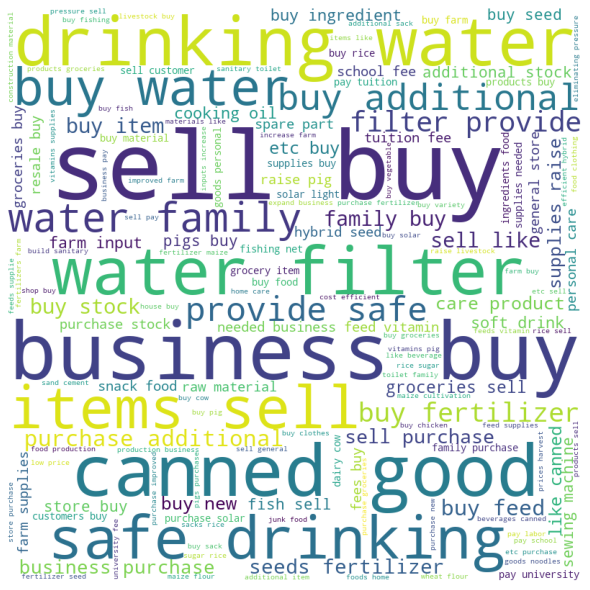

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
word_cloud = WordCloud(width = 800, height = 800,
                background_color ='white', 
                stopwords = stop_words, 
                min_font_size = 10).generate(final_successful)

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(word_cloud)
plt.axis("off") 
plt.tight_layout(pad = 0) 

print("Word cloud for successful loans")

plt.show() 

Word clound for unsuccessful loans


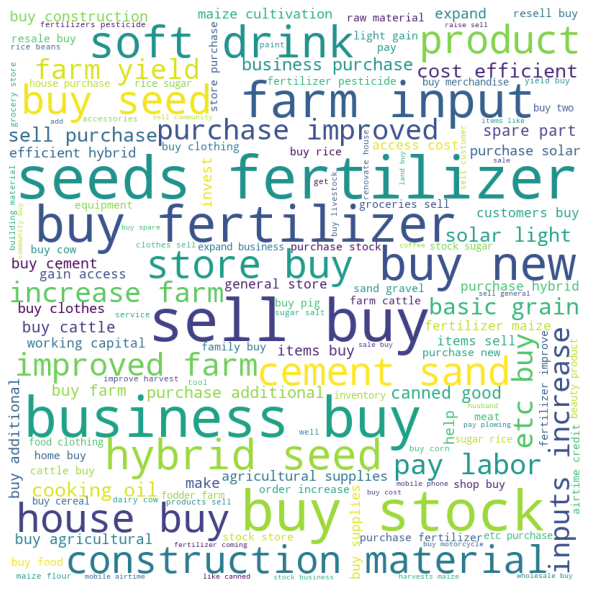

In [9]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
word_cloud = WordCloud(width = 800, height = 800,
                background_color ='white', 
                stopwords = stop_words, 
                min_font_size = 10).generate(final_unsuccessful)

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(word_cloud)
plt.axis("off") 
plt.tight_layout(pad = 0) 

print("Word cloud for unsuccessful loans")

plt.show()

### Results

Viewing the word clouds we can see that the words such as "water", "safe drinking", "water filter" are used in
successful loans, whereas "buy", "sell", "soft drink" and "business" are used more in unsuccessful loans.

### 3.2.2 Extracting Lexical Diversity, Text Length, Word Count and TF/IDF
We will extract 4 features: Lexical Diversity, Text Length, Word Count and TF/IDF.

#### 3.2.2.1 Filling missing data
We fill the missing data in order to avoid errors

In [10]:
def fill_missing_values(field, value):
    missing_values_before = loans_with_label[field].apply(lambda x: 1 if type(x) is float and math.isnan(x) else 0).sum()
    loans_with_label[field] = loans_with_label[field].fillna(value)
    missing_values_after = loans_with_label[field].apply(lambda x: 1 if type(x) is float and math.isnan(x) else 0).sum()
    print(f'Missing values in {field} - before: {missing_values_before}, after: {missing_values_after}')

fill_missing_values('partner_id', 0)
fill_missing_values('lender_count', 0)
fill_missing_values('country_code', 'na')
fill_missing_values('use', '')

Missing values in partner_id - before: 13507, after: 0
Missing values in lender_count - before: 0, after: 0
Missing values in country_code - before: 8, after: 0
Missing values in use - before: 4232, after: 0


#### 3.2.2.2 Checking the effect of each feature
We want to check how the 4 feature - Lexical Diversity, Text Length, Word Count and TF/IDF - effect the choice of the
borrower.

#### lexical diversity and word count
**we check the effect of the loan's use field lexical diversity and the number of words in the use field -
on the borrowers.**

In [11]:
import nltk
nltk.download('punkt')

unique_words = dict()
def lexical_diversity(text):
    tokenized_text = nltk.word_tokenize(text)
    if len(tokenized_text) == 0:
        return 0
    for i in tokenized_text:
        try:
            unique_words[i] += 1
        except Exception as e:
            unique_words[i] = 1
    return len(set(tokenized_text)) / len(tokenized_text)

loans_with_label['lexical_diversity'] = loans_with_label['use'].progress_apply(lexical_diversity)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\eyalg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
100%|██████████| 671203/671203 [01:24<00:00, 7939.69it/s] 


In [12]:
loans_with_label['use_length'] = loans_with_label['use'].apply(lambda x: len(x))
loans_with_label['word_count'] = loans_with_label['use'].progress_apply(lambda x: len(nltk.word_tokenize(x)))

100%|██████████| 671203/671203 [01:15<00:00, 8889.63it/s] 


#### TF-IDF
TF-IDF stands for “Term Frequency — Inverse Document Frequency”.
This is a technique to quantify a word in documents,
we generally compute a weight to each word which signifies the importance of the word in the document and corpus.


**In our case, we check the effect of each word in the "use" field - on the borrowers.**

In [13]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer 

filtered_use = loans['use'].apply(lambda x: x if not pd.isna(x) else "")

tfidf_vectorizer = TfidfVectorizer(use_idf=True)
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(filtered_use)

# get the first vector out (for the first document)
first_vector_tfidfvectorizer = tfidf_vectorizer_vectors[0]

# place tf-idf values in a pandas data frame
temp_df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"])
tfidf_df = temp_df.sort_values(by=["tfidf"],ascending=False)

In [14]:
tokenizer = nltk.RegexpTokenizer(r'\w+')
def tfidf_extraction(use):
    values = []
    for i in tokenizer.tokenize(use):
        i = i.lower()
        if i not in tfidf_df.index:
            continue
        values.append(tfidf_df.loc[i].iloc[0])
    return np.array(values).max(initial=0)

loans_with_label['tfidf'] = loans_with_label['use'].progress_apply(tfidf_extraction)

100%|██████████| 671203/671203 [10:43<00:00, 1043.38it/s]


# todo add more here and understand what tal wrote
#### Results
After analyzing the plots, it seems that the successful loans have a shorter but richer sentence in the use field.

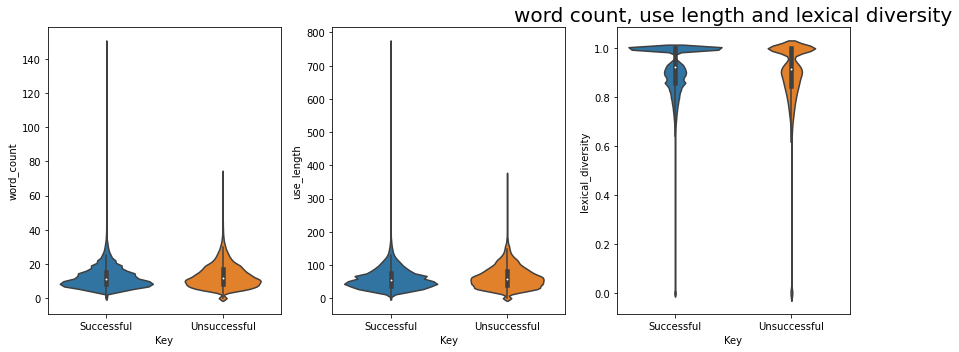

In [32]:
import seaborn as sns

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,5))
ax = sns.violinplot(x="Key", y="word_count", data=loans_with_label, ax=axes[0])
ax = sns.violinplot(x="Key", y="use_length", data=loans_with_label, ax=axes[1])
ax = sns.violinplot(x="Key", y="lexical_diversity", data=loans_with_label, ax=axes[2])

plt.tight_layout()
plt.show()

## 3.3 Posted date extraction
The dataset has 3 different date columns. Posted, funded and disbursed. <br>
- Funded time is not usable because has 100% correlation with our label (If a fund hasn't been fully funded,
it won't have funded time)
- Disbursed time column has too many missing entries.
- Posted time is the only useful column, so we'll be using it for our features.

We add 4 numeric features (day, month, year, day in the week)

In [16]:
from datetime import datetime
def time_to_feature(date_):
    date_ = datetime.strptime(date_, "%Y-%m-%d %H:%M:%S+00:00")
    return pd.Series({"posted_year": date_.year, "posted_month": date_.month, "posted_day": date_.day, "posted_weekday": date_.weekday(), "posted_hour": date_.hour})

posted_time_series = loans_with_label['posted_time'].progress_apply(time_to_feature)

100%|██████████| 671203/671203 [03:24<00:00, 3284.50it/s]


In [17]:
loans_with_label = loans_with_label.merge(posted_time_series, left_index=True, right_index=True)

## 3.4 Tags
The tags column contains one cell for each loan entry.
This single cell might contain more than one tag, in order to use this data we'll have to create a feature for each
different tag that exists in dataset set. <br>
The tags column might be useful, so we will have to preprocess it.<br>
This section adds tags as independent columns. It takes a while to compute.

### 3.4.1 Tags preprocessing

In [18]:
def get_tag_list(tags):
    stags = set()
    if type(tags) != str:
        return set()
    tags = tags.split(",")
    for tag in tags:
        tag = tag.strip("# '")
        stags.add(tag)
    return stags

all_tags = set()
for tags in loans.tags:
    all_tags.update(get_tag_list(tags))
print(f'Total tags obtained: {len(all_tags)}')

loans_with_label['tag_list'] = loans_with_label.apply(lambda r: get_tag_list(r['tags']), axis=1)

Total tags obtained: 35


### 3.4.2 Tags extraction
Adding each tag as a feature

In [19]:
for tag in tqdm(all_tags):
    loans_with_label[f'{tag}_tag'] = loans_with_label.apply(lambda r: tag in r['tag_list'], axis=1)
    

100%|██████████| 35/35 [03:35<00:00,  6.16s/it]


### 3.4.3 Tags selection

Processing the effect of the tags on the loan's success

In [20]:
tag_names = [tag + '_tag' for tag in all_tags]
tags_df = pd.DataFrame(index=tag_names, columns =['successful', 'unsuccessful'])
appearance_tags_df = pd.DataFrame(columns =['successful', 'unsuccessful'])
successful_with_tags = loans_with_label.query("Key == 'Successful'")
unsuccessful_with_tags = loans_with_label.query("Key == 'Unsuccessful'")
for tag in tag_names:    
    sudf_num = int(successful_with_tags[successful_with_tags[tag] == 1].count().iloc[0] / successful_with_tags.count().iloc[0] * 100)
    undf_num = int(unsuccessful_with_tags[unsuccessful_with_tags[tag] == 1].count().iloc[0] / unsuccessful_with_tags.count().iloc[0] * 100)
    tags_df.loc[tag] = [sudf_num, undf_num]
    if sudf_num != 0 or undf_num != 0:
        appearance_tags_df.loc[tag] = [sudf_num, undf_num]


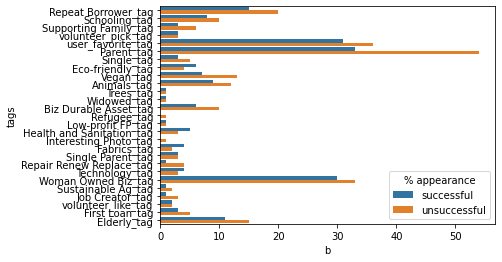

In [33]:
appearance_tags_df.index.name = 'tags'
tags_df_melted = appearance_tags_df.reset_index().melt(var_name='% appearance', value_name='b', id_vars=['tags'])
ax = sns.barplot(y='tags', x='b', hue='% appearance', data=tags_df_melted)

#### Results

Looking at the results - it seems that the tags: Technology, Fabrics, Eco-Friendly, Health and Sanitation are the top
 tags for successful loans. However, the Refugee and Interesting photo tags were always in unsuccessful loans.

using only 'user_favorite' tag

In [23]:
tags_selected = ['user_favorite_tag']

### 3.5.1 Loan amount by sector

Here we get an impression of which loan sectors are more likely to be funded.

<AxesSubplot:xlabel='sector'>

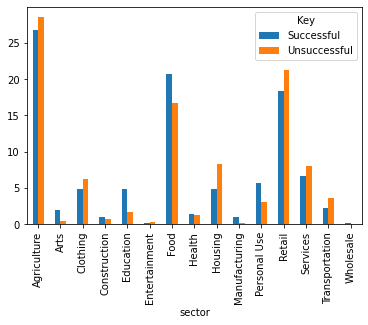

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

sectors = loans.sector.unique()

sector_loans_df = loans_with_label.groupby(["sector", "Key"]).size().unstack("Key")
sector_loans_df["Successful"] = sector_loans_df["Successful"].apply(lambda x: x / len(successful_loans_df) * 100)
sector_loans_df["Unsuccessful"] = sector_loans_df["Unsuccessful"].apply(lambda x: x / len(unsuccessful_loans_df) * 100)
sector_loans_df.plot(kind="bar")

#### Results

The ratios seem to be even among successful and unsuccessful loans, but some field seem to be more likely to be more
successful (Personal use, Education and food).

#### 3.5.2 Loan amount by sector

Let's look at average loan amount per sector of successful and unsuccessful loans:

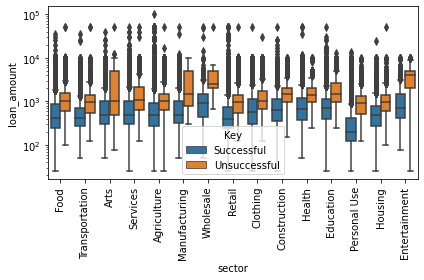

In [25]:
ax = sns.boxplot(x="sector", y="loan_amount", data=loans_with_label, hue="Key")
ax.set_yscale("log")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()

#### Results

For each sector, the average loan amount is greater on unsuccessful loans.

We can also see which sector requests for higher loans, and what is the average request that succeeds (for each sector).

#### 3.5.3 Loan amount

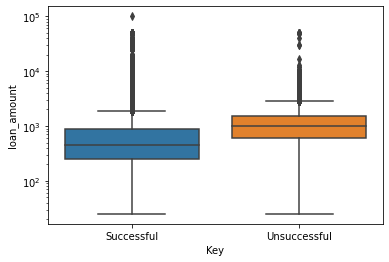

In [26]:
ax = sns.boxplot(x="Key", y="loan_amount", data=loans_with_label)
# ax.set_xticklabels(["Successful", "Unsuccessful"])
ax.set_yscale('log')
plt.show()

#### Results

On average, unsuccessful loans request higher amounts

### 3.5.4 Term in months

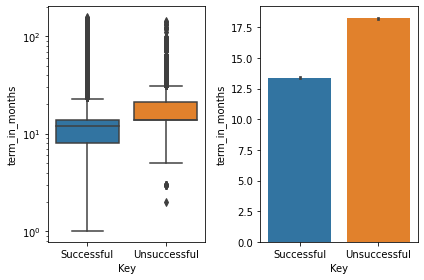

In [27]:
plt.subplot(1, 2, 1)
ax = sns.boxplot(x="Key", y="term_in_months", data=loans_with_label)
ax.set_yscale('log')
plt.subplot(1, 2, 2)
ax = sns.barplot(x="Key", y="term_in_months", data=loans_with_label)

plt.tight_layout()
plt.show()

#### Results

We can see here that on average, unsuccessful loans request for a longer term to return the loans.

#### 3.5.1.5 Repayment interval

<AxesSubplot:xlabel='repayment_interval'>

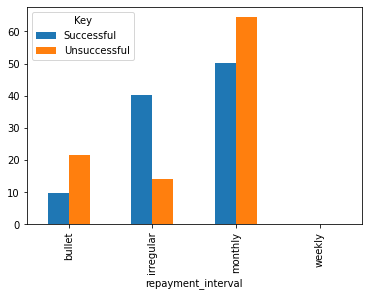

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

repayment_intervals = loans_with_label.repayment_interval.unique()


loans_by_repayment = loans_with_label.groupby(["Key", "repayment_interval"]).size().unstack("Key")
loans_by_repayment["Successful"] = loans_by_repayment["Successful"].apply(lambda x: x / len(successful_loans_df) * 100)
loans_by_repayment["Unsuccessful"] = loans_by_repayment["Unsuccessful"].apply(lambda x: x / len(unsuccessful_loans_df) * 100)
loans_by_repayment.plot(kind="bar")

#### Results

Most of the unsuccessful loans have monthly repayment interval, while almost 50% of the successful loans have irregular
interval. It seems a bit odd, since borrowers might prefer a safer repayment method, but this is probably a classic
case of causation != correlation. There's probably a probably different cause for this diff on the interval rate, but
nevertheless it can be a useful feature.

#### 3.5.2.3 MPI

ValueError: Could not interpret input 'MPI Urban'

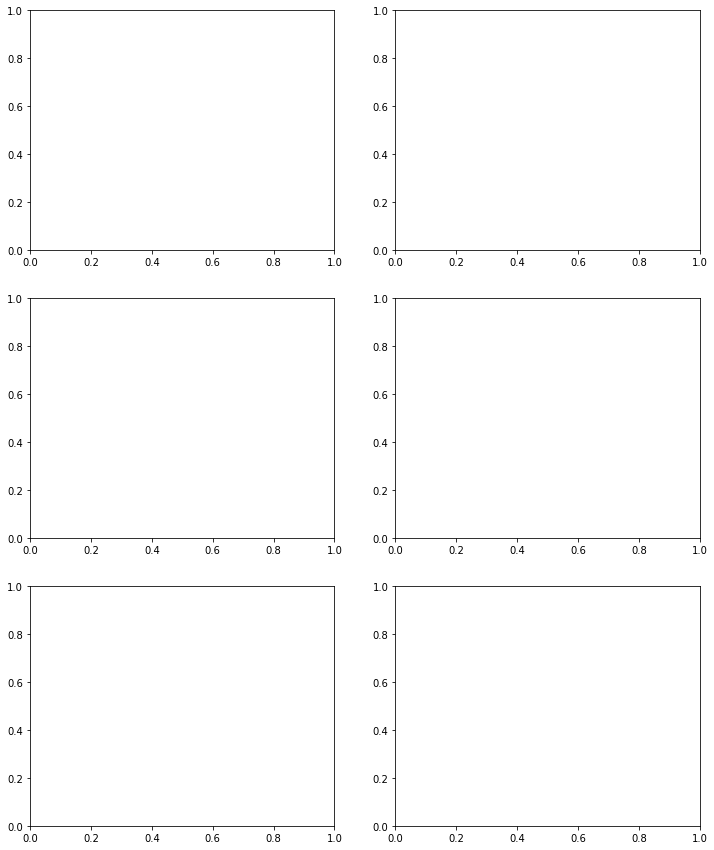

In [29]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,15))

ax = sns.violinplot(x="Key", y="MPI Urban", data=loans_with_label, ax=axes[0, 0])
ax = sns.violinplot(x="Key", y="MPI Rural", data=loans_with_label, ax=axes[0, 1])
ax = sns.violinplot(x="Key", y="Headcount Ratio Urban", data=loans_with_label, ax=axes[1, 0])
ax = sns.violinplot(x="Key", y="Headcount Ratio Rural", data=loans_with_label, ax=axes[1, 1])
ax = sns.violinplot(x="Key", y="Intensity of Deprivation Urban", data=loans_with_label, ax=axes[2, 0])
ax = sns.violinplot(x="Key", y="Intensity of Deprivation Rural", data=loans_with_label, ax=axes[2, 1])

plt.tight_layout()
plt.show()

In [ ]:
plt.subplot(2, 2, 1)
ax = sns.barplot(x="Key", y="MPI National", data=loans_with_label)
plt.subplot(2, 2, 2)
ax = sns.barplot(x="Key", y="MPI Regional", data=loans_with_label)
plt.subplot(2, 2, 3)
ax = sns.barplot(x="Key", y="Headcount Ratio Regional", data=loans_with_label)
plt.subplot(2, 2, 4)
ax = sns.barplot(x="Key", y="Intensity of deprivation Regional", data=loans_with_label)
plt.tight_layout()
plt.show()

These plots show the MPI information of successful and unsuccessful loans. <br>
The pattern is that the MPI index is greater among the successful loans, on average, for both the regional MPI and National MPI. <br>
This means, that most of the successful loans are aimed toward countries with higher MPI index (or in other words, the people who needs the loans the most)


## 3.6 Selected Features

These dataframes (undf, sudf) will be used for the final composition of the data set.

In [ ]:
selected_features_df = loans_with_label.loc[:, ['Key',
    'loan_amount', 'sector', 'activity', 'term_in_months', 'repayment_interval', 
    'MPI Urban', 'Headcount Ratio Urban', 'Intensity of Deprivation Urban', 'MPI Rural', 'Headcount Ratio Rural',
    'Intensity of Deprivation Rural', 'partner_id', 'country_code', 'borrowers_amount', 'has_male', 'has_female',
    'posted_year','posted_month', 'posted_day', 'posted_weekday', # 'posted_hour', 
    'lexical_diversity', 'use_length', 'word_count',  'lender_count', 
    'MPI National', 'MPI Regional', 'Headcount Ratio Regional', 'Intensity of deprivation Regional', 
    'tfidf',
] + tags_selected]
print(f'number of features: {len(selected_features_df.columns)}')

In [ ]:
selected_features_df.groupby("Key").size()

#  <a class="anchor" id="encoding">4. Encoding</a>
We have some other relevant features to be encoded before we can use them.

## 4.1 Encoding Features
Now we will encode the feature on the whole dataset.

In [ ]:
from sklearn.preprocessing import LabelEncoder

sector_le = LabelEncoder()
activity_le = LabelEncoder()
pay_int_le = LabelEncoder()
country_code_le = LabelEncoder()
has_male_le = LabelEncoder()
has_female_le = LabelEncoder()

In [ ]:
country_code_le.fit(selected_features_df['country_code'])

sector_le.fit(selected_features_df['sector'].unique())
activity_le.fit(selected_features_df['activity'].unique())
pay_int_le.fit(selected_features_df['repayment_interval'])
selected_features_df['sector'] = sector_le.transform(selected_features_df['sector'])
has_male_le.fit(selected_features_df['has_male'])
has_female_le.fit(selected_features_df['has_female'])

selected_features_df['activity'] = activity_le.transform(selected_features_df['activity'])
selected_features_df['repayment_interval'] = pay_int_le.transform(selected_features_df['repayment_interval'])
selected_features_df['country_code'] = country_code_le.transform(selected_features_df['country_code'])
selected_features_df['has_male'] = has_male_le.transform(selected_features_df['has_male'])
selected_features_df['has_female'] = has_male_le.transform(selected_features_df['has_female'])

for tag in tags_selected:
    le = LabelEncoder()
    le.fit(selected_features_df[tag])
    selected_features_df[tag] = le.transform(selected_features_df[tag])

In [ ]:
selected_features_df.describe()

## 4.2  Biased encoding
On our previous attempt we separated the label using different dataframes (we didn't merge unsuccessful_loans_df and successful_loans_df). When we applied and proccesed the features, we've done the processing for both the dataframes. <br>
Eventually, when we reached the encoding, we had to encode them separatly as well. Since we've encoded the succeessful and unsuccessful entries one after the other, our encoded data had biased value. <br>
The data was biased because some of the encoded value existed only in one of the datasets, so the DNN could classify the data with a great success rate using only the encoded data. <br>
With the biased encdoing we've reached success rate of 99%...

#  <a class="anchor" id="models">5. Models</a>
## 5.1 Introduction


### 5.1.1 POC SGDClassifier (initial model)
The first model we trained for the proposal of this notebook was SGDClassifier. The results weren't very promising, they are presented here as a reference:<br>
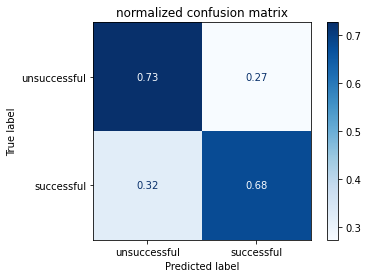
<br>


### 5.1.2 Further Models
We continued the research and trained an MLPClassifier (DNN model) and gained much better results! 
We have 1 SGD model and 3 DNN models. 
- DS1 - The SGD simply includes all of our extracted features, and we'll be able to see the improvement from the POC
- DS2 - The first DNN was trained on the same dataset as the last SGDClassifier, and does not include regional MPI data. We wanted to compare the results of a DNN and an SGD models, without changing the data or the features.
- DS3 - The second DNN is the same as the first one, but we tried to deal with the unbalanced dataset using oversampling. It should be compared to DS2.
- DS4 - In this model, we tried to deal with the imbalanced data by building imbalanced datasets. The successful loans amount in the training set is double in size, compared to the unsuccessful loans amount.
- DS5 - The last DNN includes the regional MPI features. Except that, it was trained on the same dataset as the first DNN model, so it should be compared to DS2.

The models, including composition, training and testing, are presented below.


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

### 5.1.3 Randomizing and initial sizes

In [ ]:
# selected_features_df = selected_features_df.sample(frac=1).reset_index(drop=True)
sudf_main = selected_features_df.query("Key == 'Successful'").drop(["Key"], axis=1)
undf_main = selected_features_df.query("Key == 'Unsuccessful'").drop(["Key"], axis=1)
sudf_main = sudf_main.sample(frac=1).reset_index(drop=True)
undf_main = undf_main.sample(frac=1).reset_index(drop=True)
print(f'amount of successful loans: {len(sudf_main)}')
print(f'amount of unsuccessful loans: {len(undf_main)}')

As we can see here, the data isn't balanced. We present here 3 possible solutions, solutions 1+2 will be exemplified as DS2 and DS3 correspondingly:
1. <b>reducing the succesful samples</b> - since there are less unsuccessful samples, an appropriate approach is not to use all the successful loans data.
2. <b>oversampling</b> - duplication of existing unsuccessful samples in order to enlarge the data set size.
3. <b>using imbalance datasets</b> - using data "as-is", by that taking more successful loans than unsuccessful loans. The simplest approach, but might lead to biases (the results were bad, so won't be presented here).

## 5.2 Extended SGDClassifier (DS1)
The extended SGDClassifier model includes all the features we have seen above in the feature engineering process. We've added dozens of features, which lead to much better results than the POC model.<br>
To make it clear - this model is the same one as the SGDClassifier in the POC, except the features we've added, which improved the results.

### 5.2.1 Composition
Since there are less unsuccessful loans, we took 2/3 of them for training and corresponding amount from the sucesssful loans. The rest (a third of the unsuccessful and a corresponding amount of the successful) will be used for test.<br>

In [ ]:
sudf = sudf_main.drop(['MPI National', 'MPI Regional', 'Headcount Ratio Regional', 'Intensity of deprivation Regional'], axis=1)
undf = undf_main.drop(['MPI National', 'MPI Regional', 'Headcount Ratio Regional', 'Intensity of deprivation Regional'], axis=1)

# take only 2/3 of the data for training (based on undf size, since undf is 39,878 and sudf is 550,560)
count = int(len(undf) * 2 / 3)
print(f'size of training set (successful and unsuccessful): {count*2}')
Y = []
Y.extend(np.zeros(count)) # for unsuccessful loans - undf
Y.extend(np.ones(count)) # for successful loans - sudf
Y = np.array(Y)
X = pd.concat([undf[:count], sudf[:count]], ignore_index=True)

# predict test set - 1/3 of the undf data, or 1/2 of the training set
end_test_set_count = int(3*count/2) + 1
print(f'size of test set (successful and unsuccessful): {count}')

X_test = pd.concat([undf[count:], sudf[count:end_test_set_count]], ignore_index=True).reset_index(drop=True)
y_test = np.concatenate((np.zeros(int(count/2)+1), np.ones(int(count/2)+1)))

### 5.2.2 Training

In [ ]:
from sklearn.linear_model import SGDClassifier

classifier = SGDClassifier(max_iter=1000)
clf = make_pipeline(StandardScaler(),classifier)
clf.fit(X, Y)

### 5.2.3 Testing

In [ ]:
from sklearn.metrics import plot_confusion_matrix

disp = plot_confusion_matrix(clf, X_test, y_test,
                             display_labels=['unsuccessful','successful'],
                             cmap=plt.cm.Blues,
                             normalize='true',
                            values_format='.4g')
disp.ax_.set_title('normalized confusion matrix')
print(disp.confusion_matrix)

## 5.3 Basic MLPClassifier (DS2)
We use here the same data sets (composition, features) as we used for the Extended SGDClassifier, so we can compare the results of MLP against SGD.<br>
The data was not oversampled. Also, it doesn't include any new features.

### 5.3.1 Composition
Same as the Extended SGDClassifier.

In [ ]:
sudf = sudf_main.drop(['MPI National', 'MPI Regional', 'Headcount Ratio Regional', 'Intensity of deprivation Regional'], axis=1)
undf = undf_main.drop(['MPI National', 'MPI Regional', 'Headcount Ratio Regional', 'Intensity of deprivation Regional'], axis=1)

In [ ]:
# take only 2/3 of the data for training (based on undf size, since undf is 39,878 and sudf is 550,560)
count = int(len(undf) * 2 / 3)
print(f'size of training set (successful and unsuccessful): {count*2}')
Y = []
Y.extend(np.zeros(count)) # for unsuccessful loans - undf
Y.extend(np.ones(count)) # for successful loans - sudf
Y = np.array(Y)
X = pd.concat([undf[:count], sudf[:count]], ignore_index=True)

# predict test set - 1/3 of the undf data, or 1/2 of the training set
end_test_set_count = int(3*count/2) + 1
print(f'size of test set (successful and unsuccessful): {count}')

X_test = pd.concat([undf[count:], sudf[count:end_test_set_count]], ignore_index=True).reset_index(drop=True)
y_test = np.concatenate((np.zeros(int(count/2)+1), np.ones(int(count/2)+1)))


### 5.3.2 Training

In [ ]:
classifier = MLPClassifier(max_iter=500, hidden_layer_sizes=(15, 15, 15))
clf = make_pipeline(StandardScaler(),classifier)
clf.fit(X, Y)

### 5.3.3 Testing

In [ ]:
from sklearn.metrics import plot_confusion_matrix

disp = plot_confusion_matrix(clf, X_test, y_test,
                             display_labels=['unsuccessful','successful'],
                             cmap=plt.cm.Blues,
                             normalize='true',
                            values_format='.4g')
disp.ax_.set_title('normalized confusion matrix')
print(disp.confusion_matrix)


### 5.3.4 Results Analysis
The results on the first test set are much better than the Extended SGDClassifier model (DS1). From now on, we will present only MLP models.

In [ ]:
plt.plot(classifier.loss_curve_)

### 5.3.4 Testing the remaining successful loans
Since we don't use all the successful loans, we can utilize the rest as another benchmark on successful loans solely. The results are pretty impressive.

In [ ]:
X_success_test = sudf[count:].reset_index(drop=True)
y_success_test = np.ones(len(X_success_test))

disp = plot_confusion_matrix(clf, X_success_test, y_success_test,
                             display_labels=['unsuccessful','successful'],
                             cmap=plt.cm.Blues,
                             normalize='true',
                            values_format='.4g')
disp.ax_.set_title('normalized confusion matrix')
print(disp.confusion_matrix)


## 5.4 Oversampled MLPClassifier (DS3)

This dataset involves a technique called oversampling. Since we have less unsuccessful data, we'd like to oversample the existing data. That way, we can use more unique successful data, and enlarge the general size of the data set.<br>

### 5.4.1 Composition
For this training cycle, we split the unsuccessful loans again into two parts:<br>
* two thirds - for training (to be oversampled)
* a third - for testing
<br>

We took a corresponding amount of successful loans for both training and test sets.

In [ ]:
from collections import Counter

# undf - take only 2/3 of the data for training
sudf_training_count = int(len(sudf) * 2 / 3)
undf_training_count = int(len(undf) * 2 / 3)

# predict test set - 1/3 of the undf data
sudf_test_count = int(len(sudf) / 3)
undf_test_count = int(undf_training_count / 2)

# print(f'size of training set (successful and unsuccessful): {count*2}')
Y_to_re = []
Y_to_re.extend(np.zeros(undf_training_count)) # for unsuccessful loans - undf
Y_to_re.extend(np.ones(sudf_training_count)) # for successful loans - sudf
Y_to_re = np.array(Y_to_re)
X_to_re = pd.concat([undf[:undf_training_count], sudf[:sudf_training_count]], ignore_index=True)
print(f'size of training (x): {len(X_to_re)}, size of training label (Y): {len(Y_to_re)}')

test_undf = undf[-undf_test_count:]
test_sudf = sudf[-undf_test_count:]
X_test_to_re = pd.concat([test_undf, test_sudf], ignore_index=True).reset_index(drop=True)
Y_test_to_re = np.concatenate((np.zeros(undf_test_count), np.ones(undf_test_count)))
print(f'size of test (x): {len(X_test_to_re)}, size of test label (Y): {len(Y_test_to_re)}')

print(Counter(Y_to_re))

### 5.4.2 Oversampling
Here we extend the unsuccessful loans to be the same size as the successful loans, using oversampling.

In [ ]:
from imblearn.over_sampling import SMOTE

X_resampled, Y_resampled = SMOTE(sampling_strategy='minority').fit_resample(X_to_re,Y_to_re)
print(f'new size of training samples (x): {len(X_resampled)}, training labeled (Y): {len(Y_resampled)}')

print(Counter(Y_resampled))

### 5.4.3 Training

In [ ]:
# train a model
classifier_resampling = MLPClassifier(max_iter=500, hidden_layer_sizes=(15, 15, 15))
clf_resampling = make_pipeline(StandardScaler(),classifier_resampling)
clf_resampling.fit(X_resampled, Y_resampled)


### 5.4.4 Testing

In [ ]:
# predict test set
from sklearn.metrics import plot_confusion_matrix
disp = plot_confusion_matrix(clf_resampling, X_test_to_re, Y_test_to_re,
                             display_labels=['unsuccessful','successful'],
                             cmap=plt.cm.Blues,
                             normalize='true',
                            values_format='.4g')
disp.ax_.set_title('normalized confusion matrix')
print(disp.confusion_matrix)



### 5.4.5 Results Analysis
The results (compared to the Basic MLPClassifier) on the successful loans remain the same. However, the unsuccessful loans seem to be worse. The oversampling might be too aggressive, or it might just not be the right solution to the problem.

### 5.4.6 Another oversampled model
In order to test our hypothesis, we trained another oversampled model, but only x2 for the unsuccessful loans (instead of x12 in the last one).<br>
The results indicate our hypothesis. The successful loans seem to be better than the Basic MLPClassifier, but worse than the first oversampled model. The same results work for the unsuccessful loans.<br>
The bottom line is that we find here a correlation between the uniqueness of the data and the results we achieve on it (oversampled data -> worse results, unique data -> better results).

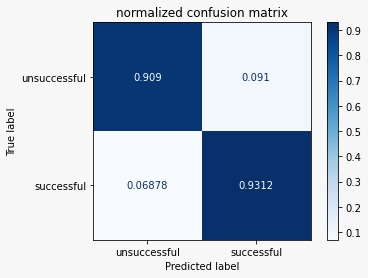

## 5.5 Imbalanced MLPClassifier (DS4)
This model was trained with imbalanced data sets. We took the unsuccessful data as is, and added to the training set a double amount of successful data.

### 5.5.1 Composition

In [ ]:
from collections import Counter

# undf - take only 2/3 of the data for training
undf_training_count = int(len(undf) * 2 / 3)

# predict test set - 1/3 of the undf data
undf_test_count = int(len(undf) / 3)

# print(f'size of training set (successful and unsuccessful): {count*2}')
Y_imb = []
Y_imb.extend(np.zeros(undf_training_count)) # for unsuccessful loans - undf
Y_imb.extend(np.ones(undf_training_count*2)) # for successful loans - sudf
Y_imb = np.array(Y_imb)
X_imb = pd.concat([undf[:undf_training_count], sudf[:undf_training_count*2]], ignore_index=True)
print(f'size of training (x): {len(X_imb)}, size of training label (Y): {len(Y_imb)}')

test_undf_imb = undf[undf_training_count:]
test_sudf_imb = sudf[:-len(test_undf_imb)]
X_test_imb = pd.concat([test_undf_imb, test_sudf_imb], ignore_index=True).reset_index(drop=True)
Y_test_imb = np.concatenate((np.zeros(len(test_undf_imb)), np.ones(len(test_sudf_imb))))
print(f'size of test (x): {len(X_test_imb)}, size of test label (Y): {len(Y_test_imb)}')

print(Counter(Y_imb))

### 5.5.2 Training

In [ ]:
# train a model
classifier_imb = MLPClassifier(max_iter=500, hidden_layer_sizes=(15, 15, 15))
clf_imb = make_pipeline(StandardScaler(),classifier_imb)
clf_imb.fit(X_imb, Y_imb)

### 5.5.3 Testing

In [ ]:
# predict test set
from sklearn.metrics import plot_confusion_matrix
disp = plot_confusion_matrix(clf_imb, X_imb, Y_imb,
                             display_labels=['unsuccessful','successful'],
                             cmap=plt.cm.Blues,
                             normalize='true',
                            values_format='.4g')
disp.ax_.set_title('normalized confusion matrix')
print(disp.confusion_matrix)

### 5.5.4 Results Analysis
The imbalanced model is proved to be similar to the Basic MLPClassifier. We have worse prediction on the unsuccessful loans by 3%, but better prediction on the successful loans by 3% as well.

## 5.6 Regional MPI MLPClassifier (DS5)
For this model training, we partially extracted the regional data from MPI. We extracted a large portion of the regions, and after seeing the initial results we concluded that this direction does not improve.<br>
We've filled MPI, head count and Intensity with 0s. <br>
Please note that the name is "regional MPI" and not just "MPI", since the country MPI data is already included in all the previous models. Here we add the regional MPI data.


### 5.6.1 Preprocessing - Merge Regional MPI

### Filter Columns

In [ ]:
undf1 = undf_main
sudf1 = sudf_main

### Prepare train and test samples

In [ ]:
# take only 2/3 of the data for training (based on undf size, since undf is 39,878 and sudf is 550,560)
count = int(len(undf1) * 2 / 3)
print(f'size of training set (successful and unsuccessful): {count*2}')
Y = []
Y.extend(np.zeros(count)) # for unsuccessful loans - undf
Y.extend(np.ones(count)) # for successful loans - sudf
Y = np.array(Y)
X = pd.concat([undf1[:count], sudf1[:count]], ignore_index=True)

# predict test set - 1/3 of the undf data, or 1/2 of the training set
end_test_set_count = int(3*count/2) + 1
print(f'size of test set (successful and unsuccessful): {count}')

X_test = pd.concat([undf1[count:], sudf1[count:end_test_set_count]], ignore_index=True).reset_index(drop=True)
#X_test = np.concatenate((predict_unsuc, predict_suc))
y_test = np.concatenate((np.zeros(int(count/2)+1), np.ones(int(count/2)+1)))


### 5.6.2 Training

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    classifier = MLPClassifier(max_iter=200, hidden_layer_sizes=(20, 20, 20,))

clf1 = make_pipeline(StandardScaler(),classifier)
clf1.fit(X, Y)

### 5.6.3 Testing

In [ ]:
from sklearn.metrics import plot_confusion_matrix

disp = plot_confusion_matrix(clf1, X_test, y_test,
                             display_labels=['unsuccessful','successful'],
                             cmap=plt.cm.Blues,
                             normalize='true',
                            values_format='.4g')
disp.ax_.set_title('normalized confusion matrix')
print(disp.confusion_matrix)


### 5.6.4 Results Analysis
As we can see, the results are not better than DS2, the basic MLPClassifier.

### 5.6.5 Testing the remaining successful loans
With remaining successful loans

In [ ]:
X_success_test = sudf1[count:].reset_index(drop=True)
y_success_test = np.ones(len(X_success_test))

disp = plot_confusion_matrix(clf1, X_success_test, y_success_test,
                             display_labels=['unsuccessful','successful'],
                             cmap=plt.cm.Blues,
                             normalize='true',
                            values_format='.4g')
disp.ax_.set_title('normalized confusion matrix')
print(disp.confusion_matrix)


# 5.7 Results
We trained a very first model as a POC (SGDClassifier). The initial results indicate that there is a case for the current classification problem, however the results were too bad.<br>
Next, we added dozens of features, based on deeper research of the data. The results of the next SGDClassifier we trained were much better. We called thie model the Extended SGDClassifier. <br>
After some research, we trained the Basic MLPClassifier which proved to be better than both of them. It conludes all the features we added to the Extended SGDClassifier.<br>
We decided to continue with the MLPClassifier, and trained a few more versions of it.
We started off by showing an oversampled model, which is called Oversampled MLPClassifier. We experienced a lower prediction of the unsuccessful loans, so we tried to lower the oversampling to x2. The results were better.<br>
Next, we showed the Imbalanced MLPClassifier. Its results were similar to the second oversampling model and the Basic MLPClassifier.<br>
Last but not least, we trained the Regional MPI MLPClassifier. Its results were similar to the Basic MLPClassifier.

# <a class="anchor" id="conclusions">6. Conclusions</a>
## 6.1 Obstacles
Along the way we had some bugs that shifted our results, the most significat bug was the biased encoding, it improved our success rate significally and we didn't suspect this bug until we reviewed some of our code. <br>
Another, less impactful bug was merging the MPI and loans dataset. We didn't set the 'how' parameter, and ended up losing 80k entries which suprisinly didn't affect the results too badly. <br><br>

## 6.2 Summary
We faced various challenges in this project: missing values, features that require preprocessing, crossing data with other datasets, dealing with imbalanced datasets, and figuring out the best model for predicting the best results. Each challange required different tools and attitude, and we presented the solutions we offered to overcome them. In some cases, we compared a few solutions.<br>
One of the biggest challanges of the project was the feature extraction, and it came into effect with the largest section of our notebook dedicated to feature extraction. The model training and fine uning was also a major challenge.<br>
Our end goal was to predicit whether a loan will get fully funded on Kiva platform or not, and we managed to get a decent result at the end. Using the 2nd (the Basic MLPClassiifer) or 5th models (Regional MPI MLPClassifier) we can get a prediction with 91% success rate whether a loan will be successful or not, using the 3rd (Oversampled MLPClassifier) or the 4th (Imbalanced MLPClassifer) model we can predict successful loans with success rate of almost 95%(!) but an unsuccessful loan with 89% success rate. <br><br>